In [1]:
import h5py
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys; sys.path.insert(0, '..')
#sys.path.append('/dfs6/pub/nsankar1/pushes_bubbleML/BubbleML/sciml/models/ConvolutionalNeuralOperator')
from sciml.models.trunk_wrapper.trunk_wrapper import TrunkWrapper
from sciml.models.pdearena.unet import Unet
from sciml.op_lib.disk_hdf5_dataset import DiskTempVelDataset
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from sciml.op_lib.disk_hdf5_dataset import (
        DiskTempInputDataset,
        DiskTempVelDataset
)
from sciml.op_lib.hdf5_dataset import (
        HDF5ConcatDataset,
        TempInputDataset,
        TempVelDataset
)
%matplotlib inline
DEVICE = torch.device("cuda")

In [2]:
def collate_fn(data):
        fw = 5       
        inbatch = []
        labelbatch = []
        
        for pack in data:
            coords, temp, vel, dfun, temp_label, vel_label = pack
            input = (coords, temp, vel, dfun)
            
            for t in range(fw):
                inbatch += [input + (torch.tensor(t, device=data[0][0].device).unsqueeze(0),)]
                labelbatch += [(temp_label[:, t].unsqueeze(1), vel_label[:, t*2:(t+1)*2])]
        del pack
        return tuple(list(map(torch.cat, zip(*inbatch)))+list(map(torch.cat, zip(*labelbatch))))

In [3]:
checkpoint_path = "/dfs6/pub/nsankar1/pushes_bubbleML/BubbleML/examples/TrunkWrapper_vel_dataset_250_1710179483.pt"
experiment_yaml_file = "/dfs6/pub/nsankar1/pushes_bubbleML/BubbleML/conf/experiment/experimental/trunk_net/unet_trunk.yaml"

with open(experiment_yaml_file, 'r') as file:
    model_params = yaml.safe_load(file)

checkpoint = torch.load(checkpoint_path)

val_file = '/share/crsp/lab/amowli/share/BubbleML2/PoolBoiling-WallSuperheat-FC72-2D/Twall-110.hdf5'
val_dataset = HDF5ConcatDataset([TempVelDataset(val_file, 0, True, False, 5, 5, 1)])
val_dataset.normalize_temp_()
val_dataset.normalize_vel_()
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


model = Unet(
             in_channels=20,
             out_channels=15,
             hidden_channels=model_params['model']['hidden_channels'],
             ch_mults=[1,2,2,4,4],
             is_attn=[False]*5,
             activation= 'gelu',
            #  mid_attn=False,
             norm=True,
             use1x1=True
            )
model.cuda()


wall temp tensor(109.2920, dtype=torch.float64)


Unet(
  (activation): GELU(approximate='none')
  (image_proj): Conv2d(20, 32, kernel_size=(1, 1), stride=(1, 1))
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (activation): GELU(approximate='none')
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (norm1): GroupNorm(1, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 32, eps=1e-05, affine=True)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): DownBlock(
      (res): ResidualBlock(
        (activation): GELU(approximate='none')
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Conv2d(32, 64, kernel_si

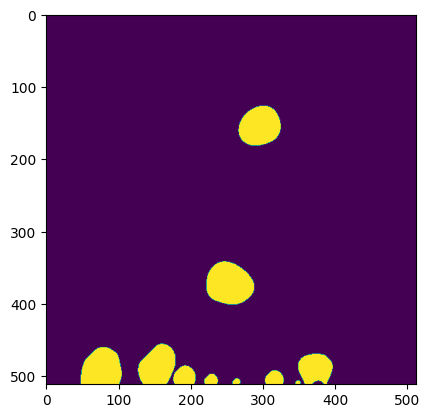

In [4]:
image = val_dataset.datasets[0]._get_timestep(0)

plt.imshow(np.flipud(image[3][0].cpu().numpy()))

In [5]:
Trunk = TrunkWrapper(model, 5, 15, 512, 512, 2, use_bias = True, func_number = 3)
Trunk.cuda()

checkpoint = torch.load(checkpoint_path)
Trunk.load_state_dict(checkpoint)

<All keys matched successfully>

/tmp/nsankar1/30979260/ipykernel_4141156/3010742997.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  trunk_val = torch.range(1, 6, requires_grad=True)


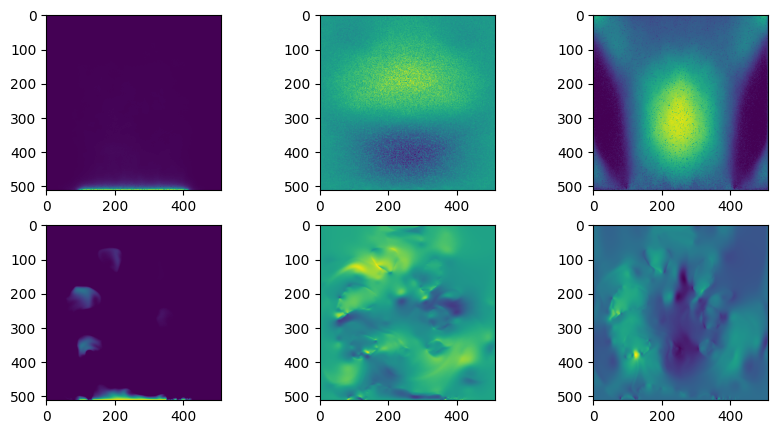

In [17]:
# input, label = (val_dataset.datasets[0]._get_timestep(0))[1:-2],(val_dataset.datasets[0]._get_timestep(0))[-2::]
it = iter(val_dataloader)

for i in range(50):
    sample = next(it)

(input, t, label) = sample[1:-3], sample[-3], sample[-2:]

# input = input.to(DEVICE).float().unsqueeze(0)
# label = label.to(DEVICE).float()

trunk_val = torch.range(1, 6, requires_grad=True)

pred = Trunk(torch.cat(input, dim = 1).cuda().float(), t.cuda().float())

# label = label.squeeze().cpu().numpy()
# pred = pred.squeeze().detach().cpu().numpy()
label = torch.cat(label, dim = 1)

fig, ax = plt.subplots(2, 3, figsize=(10, 5))

# data = {
#     'Ground Truth': label,
#     'Predicted': pred,
# }
batch = 3

for idx in range(3):
    ax[0,idx].imshow(np.flipud(pred[batch,idx,:].cpu().detach().numpy()))
    ax[1,idx].imshow(np.flipud(label[batch,idx,:].cpu().detach().numpy()))